In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [6]:
data = pd.read_csv('capitals.txt', delimiter=' ')
data.columns = ['city1', 'country1', 'city2', 'country2']

word_embeddings = pickle.load(open("word_embeddings_subset.p", "rb"))

def get_vector(word):
    return word_embeddings[word]

In [4]:
data.head(5)

,city1,country1,city2,country2
0,Athens,Greece,Bangkok,Thailand
1,Athens,Greece,Beijing,China
2,Athens,Greece,Berlin,Germany
3,Athens,Greece,Bern,Switzerland
4,Athens,Greece,Cairo,Egypt


### Cosine Similarity
**Instructions:** Implement a function that takes in two word vectors and computes the cosine distance.

In [5]:
def cosine(v,w):
    dot_product = np.dot(v,w)
    norm_v = np.linalg.norm(v)
    norm_w = np.linalg.norm(w)
    cos = dot_product/(norm_v*norm_w)
    return cos

In [8]:
king = word_embeddings['king']
queen = word_embeddings['queen']

cosine(king, queen)

0.6510957

### Euclidean distance
**Instructions:** Write a function that computes the Euclidean distance between two vectors.

In [11]:
def euclidean(v,w):
    distance = np.linalg.norm(v - w)
    return distance

In [12]:
euclidean(king, queen)

2.4796925

### Finding the country of each capital
**Instructions:**

Your task is to find the capital cities. For example, given the following words:

    1: Athens 2: Greece 3: Baghdad,

your task is to predict the country 4: Iraq.


$$d(King - Queen) = d(Man - Woman)$$
$$King - Man + Woman = Queen$$

In [36]:
def find_country(city1, country1, city2, embedding):
    
    city_1 = embedding[city1]
    country_1 = embedding[country1]
    city_2 = embedding[city2]
    
    vector = country_1 - city_1 + city_2
    
    not_use = [city1,country1,city2]
    
    similarity = -np.inf
    
    for word in embedding.keys():
        
        if word not in not_use:
            
            current_word_vector = get_vector(word)
            current_distance = cosine(vector,current_word_vector)
            
            if current_distance > similarity:
                
                similarity = current_distance
                country_2 = word
                
    return country_2, similarity

In [37]:
find_country('Athens', 'Greece', 'Cairo', word_embeddings)

('Egypt', 0.7626821)

In [39]:
find_country('Madrid', 'Spain', 'Paris', word_embeddings)

('France', 0.730887)

### Model Accuracy

In [49]:
def accuracy(embedding, data):
    
    correct = 0
    total = len(data)
    
    for row in range(len(data)):
        
        predicted_country = find_country(data.iloc[row,0], 
                                         data.iloc[row,1], 
                                         data.iloc[row,2],
                                         embedding)[0]
        
        if predicted_country == data.iloc[row,3]:
            
            correct += 1
            
    accuracy = correct / total
    
    return accuracy

In [50]:
accuracy(word_embeddings, data)

0.9192082407594425

### Plotting the vectors using PCA



- First de-mean the data
- Get the eigenvalues using linalg.eigh. Use eigh rather than eig since R is symmetric. The performance gain when using eigh instead of eig is substantial.
- Sort the eigenvectors and eigenvalues by decreasing order of the eigenvalues.
- Get a subset of the eigenvectors (choose how many principle components you want to use using n_components).
- Return the new transformation of the data by multiplying the eigenvectors with the original data.

In [67]:
def PCA(data, n):
    
    data_demeaned = data - np.mean(data, axis=0)
    
    covariance_matrix = np.cov(data_demeaned, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    
    idx_sorted = np.argsort(eigenvalues)[::-1] 
    eigenvalues_sorted = eigenvalues[idx_sorted]
    eigenvectors_sorted = eigenvectors[:,idx_sorted]
    
    eigenvectors_subset = eigenvectors_sorted[:,0:n]
    X_reduced = np.dot(eigenvectors_subset.transpose(),data_demeaned.transpose()).transpose()
    
    return X_reduced

In [79]:
words = ['oil', 'gas', 'happy', 'sad', 'city', 'town',
         'village', 'country', 'continent', 'petroleum', 'joyful']

def get_vectors(embeddings, words):
    m = len(words)
    X = np.zeros((1, 300))
    for word in words:
        X = np.vstack((X,get_vector(word)))
    return X[1:,:]

X = get_vectors(word_embeddings, words)

X_reduced = PCA(X,2) 

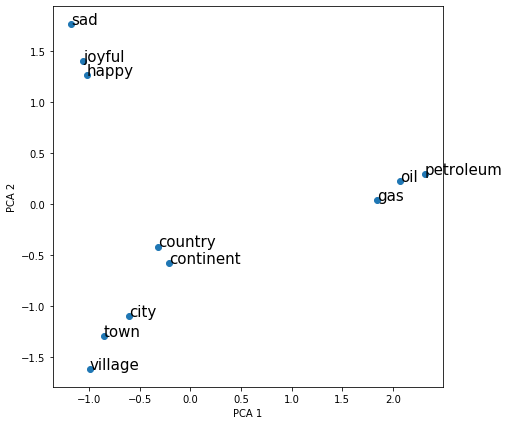

In [87]:
f, ax = plt.subplots(figsize=(7,7))

ax.scatter(X_reduced[:,0], X_reduced[:,1])

for i,word in zip(range(len(words)),words):
    ax.annotate(word,(X_reduced[i,0], X_reduced[i,1]), fontsize=15)

plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
    
plt.show()